In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import load_npz

from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import CP_ALS3 as cp
from general_functions import sqrt_err_relative

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

import warnings
warnings.filterwarnings('ignore')


def print_scores(y, y_pred):
    ps = precision_score(y, y_pred)
    rs = recall_score(y, y_pred)
    f1s = f1_score(y, y_pred)
    accs = accuracy_score(y, y_pred)
    print(f"Precision: {ps};\nRecall: {rs};\nF1: {f1s};\nAccuracy: {accs}")
    return ps, rs, f1s, accs

def construct_nuc_tensor(U, C):
    u_data = U.data
    u_indptr = U.indptr
    u_indices = U.indices

    c_data = C.data
    c_indptr = C.indptr
    c_indices = C.indices

    t_i = []
    t_j = []
    t_k = []
    t_v = []
    for i in range(n_news):
        u_val = u_data[u_indptr[i]:u_indptr[i + 1]]
        u_col = u_indices[u_indptr[i]:u_indptr[i + 1]]
        for p, j in enumerate(u_col):
            c_val = c_data[c_indptr[j]:c_indptr[j + 1]]
            c_col = c_indices[c_indptr[j]:c_indptr[j + 1]]
            for q, k in enumerate(c_col):
                t_v.append(u_val[p] * c_val[q])
                t_i.append(i)
                t_j.append(j)
                t_k.append(k)
    
    t_vals = np.array(t_v)

    t_coords = np.empty(shape=(len(t_vals), 3), dtype=int)
    t_coords[:, 0] = t_i
    t_coords[:, 1] = t_j
    t_coords[:, 2] = t_k

    return t_vals, t_coords

Using cuda device


# **BuzzFeed Dataset:**

## Load the data:

In [2]:
N = load_npz('prep_data/N_bf.npz')
U = load_npz('prep_data/U_bf.npz')
C = load_npz('prep_data/C_bf.npz')
y_labels = np.load('prep_data/labels_bf.npz')['arr_0']

n_news, n_users, n_communities = *U.shape, C.shape[1]

## Construct Tensor: News-User-Community:

In [3]:
values, coords = construct_nuc_tensor(U, C)
data_shape = n_news, n_users, n_communities
print(f"KG shape (news_articles, users, communities): {data_shape};\nThe number of nonzeros: {values.shape[0]};")

KG shape (news_articles, users, communities): (182, 15257, 81);
The number of nonzeros: 22779;


## **CMTF Decomposition (divided):**

### *CP Decomposition:*

In [4]:
# for jit/numba!
cp.cp_als3(coords[:5], values[:5], data_shape);

In [5]:
%%time

max_iter = 10 
rank = 50 
l2 =  0.5
lr = 1e-3
seed = 13 

a, b, c, err_arr, it = cp.cp_als3(
    coords, values, data_shape,
    rank=rank,
    l2=l2,
    max_iter=max_iter,
    seed=seed,
    show_iter=True,
    it_over=True,
)

rerr = sqrt_err_relative(
    coords, values, data_shape, a, b, c,
)
print(f"Relative error = {rerr}, {(np.isnan(a)).sum()}, {(np.isnan(b)).sum()}, {(np.isnan(c)).sum()}")

Iter:  1 ; Error:  0.3933223232729738
Iter:  2 ; Error:  0.03925336480935282
Iter:  3 ; Error:  0.03314904050809587
Iter:  4 ; Error:  0.031307915335348345
Iter:  5 ; Error:  0.030114551446890372
Iter:  6 ; Error:  0.02923945284546199
Iter:  7 ; Error:  0.028574339347045674
Iter:  8 ; Error:  0.028041682142023357
Iter:  9 ; Error:  0.02779509843699052
Iter:  10 ; Error:  0.027670439347604187
iterations over
Relative error = 0.027670439347604187, 0, 0, 0
CPU times: user 11min 32s, sys: 28min 3s, total: 39min 35s
Wall time: 2min 36s


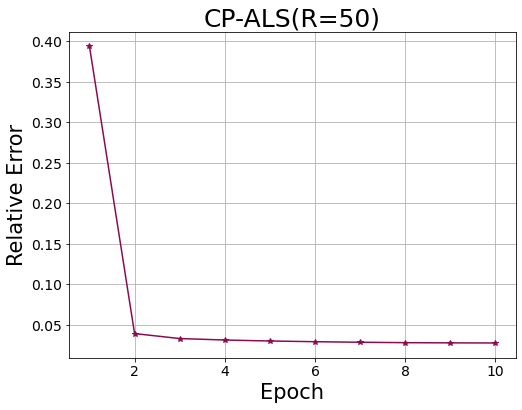

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, it + 1), err_arr[:it], '-*', c="#8b0a50")
plt.title(f"CP-ALS(R={rank})", fontsize=25)
plt.xlabel("Epoch", fontsize=21)
plt.xticks(fontsize=14)
plt.ylabel("Relative Error", fontsize=21)
plt.yticks(fontsize=14)
plt.grid(True)

### *NMF:*

In [7]:
n_factors = rank

nmf_model = NMF(
    n_components=n_factors,
    init='random',
    tol=1e-8,
    max_iter=100,#1000
    alpha_W=0.01,#0.0001
    l1_ratio=0.1,
    random_state=13,
)

N1 = nmf_model.fit_transform(N)
N2 = nmf_model.components_.T
N1.shape, N2.shape, np.linalg.norm(N - (N1 @ N2.T))

((182, 50), (3000, 50), 188.3397569098527)

## Prepare the table:

In [8]:
inds = ["Random", "XGB_N1", "XGB_N", "XGB_T1", "XGB_T1_N1", "XGB_T1_N", "DNN_T1_N"]
cols = ["Precision", "Recall", "F1_score", "Accuracy"]
buzz_table = pd.DataFrame(np.zeros((7, 4)), index=inds, columns=cols)

## **XGBoost Classification:**

### News-content NMF factorized(N1):

In [9]:
x_train, x_test, y_train, y_test = train_test_split(N1, y_labels, test_size=0.33, random_state=42)

xgb_model = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False, random_state=42, eval_metric="logloss")
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)
buzz_table.loc["XGB_N1"] = print_scores(y_pred, y_test)

Precision: 0.8064516129032258;
Recall: 0.7142857142857143;
F1: 0.7575757575757576;
Accuracy: 0.7377049180327869


### News-content full(N):

In [10]:
x_train, x_test, y_train, y_test = train_test_split(N, y_labels, test_size=0.33, random_state=42)

xgb_model = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False, random_state=42, eval_metric="logloss")
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)
buzz_table.loc["XGB_N"] = print_scores(y_pred, y_test)

Precision: 0.7419354838709677;
Recall: 0.7419354838709677;
F1: 0.7419354838709677;
Accuracy: 0.7377049180327869


### News-content CP factorized(T1):

In [11]:
x_train, x_test, y_train, y_test = train_test_split(a, y_labels, test_size=0.33, random_state=42)

xgb_model = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False, random_state=42, eval_metric="logloss")
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)
buzz_table.loc["XGB_T1"] = print_scores(y_pred, y_test)

Precision: 0.8387096774193549;
Recall: 0.7428571428571429;
F1: 0.787878787878788;
Accuracy: 0.7704918032786885


### News content CP and NMF factorized:

In [12]:
x_train, x_test, y_train, y_test = train_test_split(np.concatenate([a, N1], axis=1), y_labels, test_size=0.33, random_state=42)

xgb_model = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False, random_state=42, eval_metric="logloss")
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)
buzz_table.loc["XGB_T1_N1"] = print_scores(y_pred, y_test)

Precision: 0.8709677419354839;
Recall: 0.7297297297297297;
F1: 0.7941176470588235;
Accuracy: 0.7704918032786885


### News content CP factorized and News content full:

In [13]:
x_train, x_test, y_train, y_test = train_test_split(np.concatenate([a, N.A], axis=1), y_labels, test_size=0.33, random_state=42)

xgb_model = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False, random_state=42, eval_metric="logloss")
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)
buzz_table.loc["XGB_T1_N"] = print_scores(y_pred, y_test)

Precision: 0.8064516129032258;
Recall: 0.7575757575757576;
F1: 0.7812499999999999;
Accuracy: 0.7704918032786885


### Random baseline:

In [14]:
y_pred = np.random.choice(2, size=(len(y_test)))
buzz_table.loc["Random"] = print_scores(y_pred, y_test)

Precision: 0.6129032258064516;
Recall: 0.59375;
F1: 0.6031746031746031;
Accuracy: 0.5901639344262295


# DNN Classification:

In [15]:
torch.manual_seed(13)

In [16]:
# Define model
class DNN(nn.Module):
    def __init__(self, input_size=3050):
        super(DNN, self).__init__()
        self.dnn_stack = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0),
            nn.Linear(128, 32),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(32, 2),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.dnn_stack(x)



def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        item_x, item_y = self.x[idx], self.y[idx]
        return item_x, item_y

In [17]:
fmtx = np.concatenate([a, N.A], axis=1).astype(np.float32)

x_train, x_test, y_train, y_test = train_test_split(fmtx, y_labels, test_size=0.33, random_state=42)

batch_size = 32

training_data = CustomDataset(x_train, y_train)
test_data = CustomDataset(x_test, y_test)

# Create data loaders:
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

model = DNN(input_size=fmtx.shape[1]).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 8
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.695536  [    0/  121]
Test Error: 
 Accuracy: 72.1%, Avg loss: 0.681032 

Epoch 2
-------------------------------
loss: 0.667010  [    0/  121]
Test Error: 
 Accuracy: 72.1%, Avg loss: 0.658199 

Epoch 3
-------------------------------
loss: 0.609191  [    0/  121]
Test Error: 
 Accuracy: 77.0%, Avg loss: 0.617142 

Epoch 4
-------------------------------
loss: 0.538303  [    0/  121]
Test Error: 
 Accuracy: 83.6%, Avg loss: 0.570296 

Epoch 5
-------------------------------
loss: 0.426001  [    0/  121]
Test Error: 
 Accuracy: 83.6%, Avg loss: 0.544039 

Epoch 6
-------------------------------
loss: 0.354912  [    0/  121]
Test Error: 
 Accuracy: 83.6%, Avg loss: 0.513929 

Epoch 7
-------------------------------
loss: 0.326663  [    0/  121]
Test Error: 
 Accuracy: 83.6%, Avg loss: 0.495606 

Epoch 8
-------------------------------
loss: 0.320539  [    0/  121]
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.490838 

Done!


In [18]:
y_pred = np.array(model(torch.tensor(x_test).to(device)).argmax(axis=1).cpu())
buzz_table.loc["DNN_T1_N"] = print_scores(y_pred, y_test)

Precision: 0.8387096774193549;
Recall: 0.896551724137931;
F1: 0.8666666666666666;
Accuracy: 0.8688524590163934


In [19]:
buzz_table

,Precision,Recall,F1_score,Accuracy
Random,0.612903,0.593750,0.603175,0.590164
XGB_N1,0.806452,0.714286,0.757576,0.737705
XGB_N,0.741935,0.741935,0.741935,0.737705
XGB_T1,0.838710,0.742857,0.787879,0.770492
XGB_T1_N1,0.870968,0.729730,0.794118,0.770492
XGB_T1_N,0.806452,0.757576,0.781250,0.770492
DNN_T1_N,0.838710,0.896552,0.866667,0.868852
